In [1]:
import numpy as np
import random
from math import sqrt, exp, log, floor
from functools import partial
import matplotlib.pyplot as plt
from statistics import mean
%matplotlib inline

In [2]:
def standardize(data):
    d_mean = np.mean(data)
    d_stddev = np.std(data, ddof=1)
    if d_stddev == 0:
        return data
    return np.array([ (d-d_mean)/d_stddev for d in data ])

def standardize_xy(x_data, y_data):
    sx = np.array([ standardize(xd) for xd in x_data ])
    sy = standardize(y_data)
    return sx, sy

In [3]:
# Batch Gradient Descent

def data_converged(theta_prime, theta, p, tol):
    return sqrt(sum([ (theta_prime[i] - theta[i])**2 for i in range(p) ])) < tol

# dJ: gradient of J
# alpha: learning rate
# tol: tolerance
# init_theta: vector of inital values for theta
# max_num_rounds: max iterations of the algorithm
# x_data: x data points
# y_data: y data points
def batch_gradient_descent(dJ, alpha, tol, init_theta, max_num_rounds, x_data, y_data):
    p = len(dJ)
    assert(p == len(init_theta))
    assert(p == np.array(x_data).shape[1])
    assert(len(x_data) == len(y_data))
    
    theta = init_theta
    converged = False
    num_rounds = 0
    while not converged and num_rounds < max_num_rounds:
        num_rounds = num_rounds + 1
        theta_prime = [theta[i] - alpha * dJ[i](theta, x_data, y_data) for i in range(p)]
        converged = data_converged(theta_prime, theta, p, tol)
        theta = theta_prime
            
    return theta

In [4]:
# example for using lasso with batch GD

def dotp(x1, x2):
    return sum([x1i*x2i for (x1i,x2i) in zip(x1,x2)])

def dtheta_di_lasso(lam, i, theta, x_data, y_data):
    accum = 0.0
    for (xj,yj) in zip(x_data,y_data):
        xji = xj[i]
        accum += -2 * xji * (yj - dotp(theta,xj)) + lam*abs(theta[i])/theta[i]
    return accum

def lasso_batch_gd(lam, x_data, y_data):
    p = np.array(x_data).shape[1]
    alpha = 0.0001
    tol = 0.0001
    #init_theta = np.linalg.lstsq(x_data,y_data,rcond=None)[0]
    init_theta = np.dot( np.linalg.inv(np.dot(x_data.T,x_data) + lam*np.identity(p)), np.dot(x_data.T,y_data) )
    max_num_rounds = 100
    dJ = [ partial(dtheta_di_lasso, lam, i) for i in range(p) ]
    return batch_gradient_descent(dJ, alpha, tol, init_theta, max_num_rounds, x_data, y_data)

In [5]:
# Pathwise Coordinate Descent

def nej(j, e, k):
    return 0 if k == j else e

def sum_nej(xi, theta, j):
    return sum([ nej(j, xi[k]*theta[k], k) for k in range(len(theta)) ])

def soft_thresh(a):
    return max(a, 0)

def sign(a):
    # we can define sign(0) = 1 without any harm here because of the assert on lam in S
    return 1 if a >= 0 else -1
    
def S(t, B):
    assert(B >= 0)
    return sign(t)*soft_thresh(abs(t) - B)

# A template for Pathwise CD.  A and B are parameters that depend on the objective function
# we wish to maximize
def pathwise_cd(A, B, x_data, y_data):
    assert(A >= 0)
    assert(B >= 0)
    assert(len(x_data.shape) == 2) # x_data must be 2D
    assert(len(y_data.shape) == 1) # y_data must be 1D
    N = x_data.shape[0]
    p = x_data.shape[1]
    assert(N >= 2)
    assert(N == y_data.shape[0])
    #x_data, y_data = standardize_xy(x_data, y_data)
    
    initial_theta = np.linalg.lstsq(x_data,y_data,rcond=None)[0]
    #initial_theta = np.dot( np.linalg.inv(np.dot(x_data.T,x_data) + lam*np.identity(p)), np.dot(x_data.T,y_data) )
    max_num_rounds = 1000
    tol = 0.0001
    
    theta = initial_theta
    converged = False
    num_rounds = 0
    while not converged and num_rounds < max_num_rounds:
        num_rounds = num_rounds + 1
        theta_prime = theta.copy()
        for j in range(p):
            theta_prime[j] = S( sum([ xi[j]*(yi - sum_nej(xi,theta_prime,j))
                                      for (xi,yi) in zip(x_data,y_data) ]) / A,
                                B)
        converged = data_converged(theta_prime, theta, p, tol)
        theta = theta_prime
        
    return theta

In [6]:
# pathwise CD implementations depending on the objective function we wish to maximize

def lasso_pathwise_cd(lam, x_data, y_data):
    N = y_data.shape[0]
    return pathwise_cd(N-1, lam, x_data, y_data)

def elastic_net_pathwise_cd(alpha, lam, x_data, y_data):
    N = y_data.shape[0]
    A = (N-1) + 2*lam*alpha
    B = lam*(1-alpha)
    return pathwise_cd(A, B, x_data, y_data)

def ridge_pathwise_cd(lam, x_data, y_data):
    N = y_data.shape[0]
    A = (N-1) + 2*lam
    B = lam # should be 0 for ridge, but we're going to try something
    return pathwise_cd(A, B, x_data, y_data)

In [7]:
################################################################################################
############### Everything below is testing for the various algorithms above ###################
################################################################################################

In [8]:
def unif_simulation(a, b, N=1):
    return np.random.uniform(a, b, N)

def normal_simulation(mean, stddev, N):
    return np.random.normal(mean, stddev, N)

def e():
    return normal_simulation(0, np.sqrt(4), 1)[0]
    
def e_err():
    if unif_simulation(1,100) <= 10:
        if unif_simulation(1,2) == 1:
            return normal_simulation(0, np.sqrt(4), 1)[0] + 5
        else:
            return normal_simulation(0, np.sqrt(4), 1)[0] - 5
    else:
        return normal_simulation(0, np.sqrt(4), 1)[0]

def Y(f, x):
    return f(x) + e()

# creates a (n x p) design matrix
def create_design_mat(x_data, max_order):
    data = []
    for order in range(max_order + 1):
        data.append([d ** order for d in x_data])
        #data.append(standardize([d ** order for d in x_data]))
    return np.array(data).T

def calc_yhat(theta, x):
    max_order = len(theta)
    xvals = [x ** order for order in range(max_order+1)]
    return sum([theta_i*x_i for (theta_i,x_i) in zip(theta,xvals)])

In [9]:
colors = ['blue', 'green', 'brown', 'purple', 'yellow', 'lawngreen', 'darkblue', 'olive', 'greenyellow', 'silver']

def mse(y, y_hat):
    n = len(y)
    assert(n == len(y_hat))
    return sum([ (yi-yi_hat)**2 for (yi,yi_hat) in zip(y,y_hat) ]) / n

def plt_lasso_mse(algo, q, lams, design, y_data, title=None):
    p = len(design[0])
    thetas = [ algo(lam, design, y_data, q) for lam in lams ]
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    coeffs, mses = axes.flatten()
    
    for i in range(p):
        theta_is = [ theta[i] for theta in thetas ]
        coeffs.plot(lams, theta_is, color=colors[i], label=i)
    
    lam_mses = [ mse(y_data, [dotp(theta, nd) for nd in design]) for theta in thetas ]
    mses.plot(lams, lam_mses, color='b')
        
    if title == None:
        title = "q={}".format(q)
    plt.title(title)
    coeffs.legend()
    plt.show()

def plt_lasso(algo, q, lams, design, y_data, title=None):
    p = len(design[0])
    thetas = [ algo(lam, design, y_data, q) for lam in lams ]
    
    for i in range(p):
        theta_is = [ theta[i] for theta in thetas ]
        plt.plot(lams, theta_is, color=colors[i], label=i)
    if title == None:
        title = "q={}".format(q)
    plt.title(title)
    plt.legend()
    plt.show()

In [10]:
# generate a single data set and train a model using the given algorithm

def gen_data(f, p, N):
    x_data = unif_simulation(-2, 2, N)
    y_data = standardize([Y(f, x) for x in x_data])
    design = create_design_mat(x_data, p)
    return design, y_data

def train(algo, lam, f, p, N):
    x_data = unif_simulation(-2, 2, N)
    y_data = standardize([Y(f, x) for x in x_data])
    design = create_design_mat(x_data, p)
    return algo(lam, design, y_data)

def validate(y_data, design, model):
    y_hats = [ dotp(model,xi) for xi in design ]
    return mse(y_data, y_hats)

def train_and_validate(algo, lams, f, p):
    N = 50
    M = 5000
    
    x_data_train = unif_simulation(-2, 2, N)
    y_data_train = standardize([Y(f, x) for x in x_data_train])
    design_train = create_design_mat(x_data_train, p)
    design_train = np.array([ standardize(xd) for xd in design_train ])
    models = [ algo(lam, design_train, y_data_train) for lam in lams ]
    
    x_data_valid = unif_simulation(-2, 2, M)
    y_data_valid = standardize([Y(f, x) for x in x_data_valid])
    design_valid = create_design_mat(x_data_valid, p)
    design_valid = np.array([ standardize(xd) for xd in design_valid ])
    validation_mses = [ validate(y_data_valid, design_valid, model) for model in models ]
    min_mse_idx = np.argmin(validation_mses)
    print("Optimal Validation MSE: {}".format(validation_mses[min_mse_idx]))
    print("Corresponding Lambda Value: {}".format(lams[min_mse_idx]))
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    coeffs, mses = axes.flatten()
    
    for i in range(p):
        theta_is = [ theta[i] for theta in models ]
        coeffs.plot(lams, theta_is, color=colors[i], label=i)
    coeffs.axvline(x=lams[min_mse_idx], color='r')
    coeffs.legend()
    mses.plot(lams, validation_mses, color='b')
    mses.axvline(x=lams[min_mse_idx], color='r')
    plt.title(algo)
    plt.show()

In [11]:
# K-fold cross validation

def randomly_shuffle(x_data, y_data):
    xd = list(x_data.copy())
    yd = list(y_data.copy())
    x_shuff = []
    y_shuff = []
    while len(yd) > 0:
        idx = random.randrange(0, len(yd))
        x_shuff.append(xd.pop(idx))
        y_shuff.append(yd.pop(idx))
    return np.array(x_shuff), np.array(y_shuff)

def partition_data(k, x_data, y_data):
    N = len(y_data)
    sz = int(N/k)
    partitions = []
    for _ in range(int(k)):
        xd = x_data[0:sz]
        yd = y_data[0:sz]
        partitions.append((xd,yd))
        x_data = x_data[sz:None]
        y_data = y_data[sz:None]
    assert(x_data.shape[0] == 0)
    assert(y_data.shape[0] == 0)
    return partitions

def create_folds(partitions):
    folds = []
    for i in range(len(partitions)):
        xs = []
        ys = []
        for j in range(len(partitions)):
            if j != i:
                xs.extend(partitions[j][0])
                ys.extend(partitions[j][1])
        folds.append((np.array(xs),np.array(ys)))
    return folds

def cv_mse(y, y_hat):
    n = y.shape[0]
    assert(n == y_hat.shape[0])
    return sum([ (yi-yi_hat)**2 for (yi,yi_hat) in zip(y,y_hat) ]) / n

def cv_validate(y_data, design, model):
    y_hats = np.array([ model @ xi for xi in design ])
    return cv_mse(y_data, y_hats)

def cv_plot(plot, errors, lams, min_idx):
    fig, axes = plot.subplots(nrows=1, ncols=1)
    mses = axes #.flatten()
    mses.plot(lams, errors, color='b')
    mses.axvline(x=lams[min_idx], color='r')
    #mses.set_ylim(1)
    #plt.title(algo)
    plt.show()
    
def k_cross_validation(k, algo, lam, x_data, y_data):
    N = len(y_data)
    assert(N % k == 0) # for uniform group sizes
    x_data, y_data = randomly_shuffle(x_data, y_data)
    partitions = partition_data(k, x_data, y_data)
    folds = create_folds(partitions)
    #print(folds)
    theta_hats = [algo(lam, xd, yd) for xd,yd in folds]
    assert(len(partitions) == k)
    assert(len(folds) == k)
    assert(len(theta_hats) == k)
    
    # individual partitions are used for validation error
    errors = [cv_validate(yd,xd,theta_hat) for (xd, yd), theta_hat in zip(partitions, theta_hats)]
    
    for i in range(len(errors)):
        #if errors[i] > 2:
        print("err: {}, lam: {}, thetas: {}".format(errors[i], lam, theta_hats[i]))
    
    return sum(errors) / k

In [12]:
np.random.seed(7)
f = lambda x: x + x**3
p = 6
N = 20
x_data, y_data = gen_data(f, p, N)
x_data = np.array([ standardize(xd) for xd in x_data ])

nl = 50
dest = 1.2
lams = [ dest*i/nl for i in range(nl) ]
k = 5
k_cross_validation(k, lasso_pathwise_cd, 0.3, x_data, y_data)
#errors = [k_cross_validation(k, lasso_pathwise_cd, lam, x_data, y_data) for lam in lams]
#min_idx = np.argmin(errors)
#cv_plot(plt, errors, lams, min_idx)
#print("best error: {}, best lam: {}".format(errors[min_idx], lams[min_idx]))

err: 0.1227716138455787, lam: 0.3, thetas: [0.         0.         0.         0.         0.         0.42816896
 0.        ]
err: 0.19830404114239034, lam: 0.3, thetas: [0.         0.         0.         0.         0.         0.33515321
 0.        ]
err: 1.426286713843309, lam: 0.3, thetas: [0.        0.        0.        0.        0.        0.3611933 0.       ]
err: 0.6908863436942498, lam: 0.3, thetas: [0.         0.         0.         0.         0.         0.29694024
 0.        ]
err: 1.3681811066272718, lam: 0.3, thetas: [0.         0.         0.         0.         0.         0.19078024
 0.10643203]


0.76128596383056

<ipython-input-3-f26be0645092>:4: RuntimeWarning: overflow encountered in double_scalars
  return sqrt(sum([ (theta_prime[i] - theta[i])**2 for i in range(p) ])) < tol
<ipython-input-9-6951d41b2e78>:6: RuntimeWarning: overflow encountered in double_scalars
  return sum([ (yi-yi_hat)**2/n for (yi,yi_hat) in zip(y,y_hat) ]) # to prevent overflow


Optimal Validation MSE: 0.5887163220786386
Corresponding Lambda Value: 0.06666666666666667


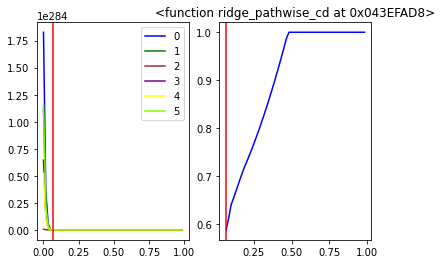

Optimal Validation MSE: 0.6929092214690357
Corresponding Lambda Value: 0.13333333333333333


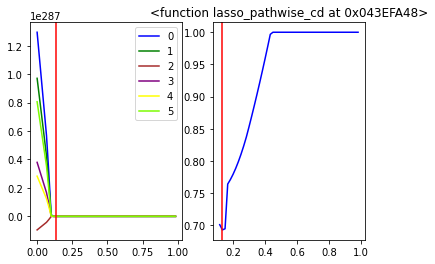

Optimal Validation MSE: 0.32714544125591943
Corresponding Lambda Value: 0.08333333333333333


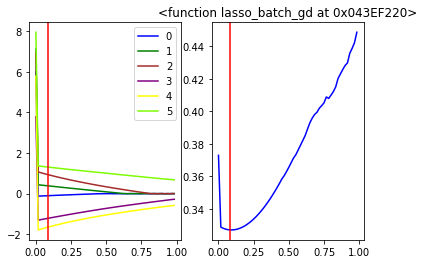

In [13]:
# Tests for algorithms that have the form: algorithm(lam, x_data, y_data)
# both lasso_pathwise_cd and lasso_batch_gd have these forms

np.random.seed(7)
f = lambda x: x + x**3
p = 6
dest = 1
n = 60
lams = [ dest*i/n for i in range(n) ]

for algo in [ridge_pathwise_cd, lasso_pathwise_cd, lasso_batch_gd]:
    train_and_validate(algo, lams, f, p)

<ipython-input-3-f26be0645092>:4: RuntimeWarning: overflow encountered in double_scalars
  return sqrt(sum([ (theta_prime[i] - theta[i])**2 for i in range(p) ])) < tol
<ipython-input-9-6951d41b2e78>:6: RuntimeWarning: overflow encountered in double_scalars
  return sum([ (yi-yi_hat)**2/n for (yi,yi_hat) in zip(y,y_hat) ]) # to prevent overflow


Optimal Validation MSE: 0.5784915753071425
Corresponding Lambda Value: 0.08333333333333333


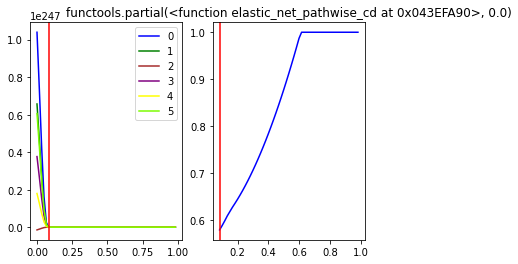

Optimal Validation MSE: 0.6806256528033351
Corresponding Lambda Value: 0.21666666666666667


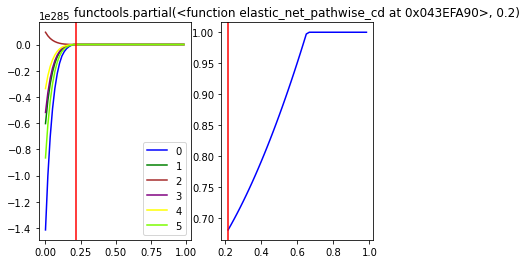

Optimal Validation MSE: 0.6123201718411916
Corresponding Lambda Value: 0.25


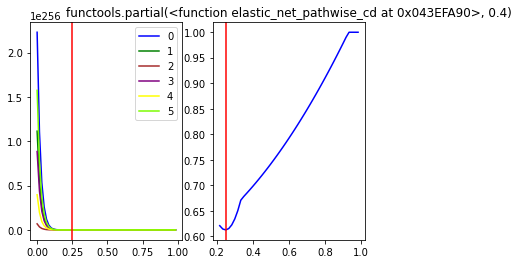

<ipython-input-5-6653567f5772>:45: RuntimeWarning: overflow encountered in double_scalars
  theta_prime[j] = S( sum([ xi[j]*(yi - sum_nej(xi,theta_prime,j))
<ipython-input-5-6653567f5772>:45: RuntimeWarning: invalid value encountered in double_scalars
  theta_prime[j] = S( sum([ xi[j]*(yi - sum_nej(xi,theta_prime,j))


In [ ]:
# tests for the elastic net; this has the form "algorithm(lam, x_data, y_data)"
# once we pass an alpha value to cen()

#np.random.seed(7)

# creates an elastic net with a specified alpha
def cen(alpha):
    return partial(elastic_net_pathwise_cd, alpha)

f = lambda x: x + x**3
p = 6
dest = 1
n = 60
lams = [ dest*i/n for i in range(n) ]

opts = 5
en_opts = [ cen(i/opts) for i in range(opts+1) ]
for algo in en_opts:
    train_and_validate(algo, lams, f, p)